In [2]:
from pathlib import Path
import datetime as dt
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
from sklearn import impute
from sklearn import preprocessing
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 7)
print("done")

done


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

for col in train.filter(regex='date', axis=1).columns:
    train[col] = pd.to_datetime(train[col])
    test[col] = pd.to_datetime(test[col])
    
# date based features
for i in range(1, 11):
    train[f'home_team_history_match_days_ago_{i}'] = (train['match_date'] - train[f'home_team_history_match_date_{i}']).dt.days
    train[f'away_team_history_match_days_ago_{i}'] = (train['match_date'] - train[f'away_team_history_match_date_{i}']).dt.days
    test[f'home_team_history_match_days_ago_{i}'] = (test['match_date'] - test[f'home_team_history_match_date_{i}']).dt.days
    test[f'away_team_history_match_days_ago_{i}'] = (test['match_date'] - test[f'away_team_history_match_date_{i}']).dt.days
    
# remove two matchs with possible error
train = train[train['home_team_name'] != train['away_team_name']].reset_index(drop=True)
    
train

C:\Users\pawar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110936 entries, 0 to 110935
Columns: 210 entries, id to away_team_history_match_days_ago_10
dtypes: datetime64[ns](21), float64(182), int64(2), object(5)
memory usage: 177.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Columns: 209 entries, id to away_team_history_match_days_ago_10
dtypes: bool(1), datetime64[ns](21), float64(182), int64(2), object(3)
memory usage: 115.5+ MB


In [8]:
print('Train:')
print('First match at:', train['match_date'].min())
print('Last match at: ', train['match_date'].max())
print('Range:', train['match_date'].max() - train['match_date'].min())

Train:
First match at: 2019-12-01 00:45:00
Last match at:  2021-05-01 00:00:00
Range: 516 days 23:15:00


In [9]:
print('Test:')
print('First match at:', test['match_date'].min())
print('Last match at: ', test['match_date'].max())
print('Range:', test['match_date'].max() - test['match_date'].min())

Test:
First match at: 2021-05-01 00:15:00
Last match at:  2021-11-30 23:30:00
Range: 213 days 23:15:00


In [10]:
validation_split = dt.datetime.strptime(
    '2021-05-01 00:00:00', '%Y-%m-%d %H:%M:%S') - dt.timedelta(days=213, hours=23, minutes=15)
print('Train until:', validation_split)

Train until: 2020-09-29 00:45:00


In [11]:
class CFG:
    seed = 42
    classes = 3
    use_class_weights = False
    batch_size = 512
    epochs = 100
    early_stopping_patience = epochs // 10
    mask = -999.0
    timesteps = 10
    target = 'target_int'
    historical_features = [
        # home based
        'home_team_history_goal',
        'home_team_history_opponent_goal',
        'home_team_history_is_play_home', 
        'home_team_history_rating',
        'home_team_history_opponent_rating',
        'home_team_history_match_days_ago',
        
        # away based
        'away_team_history_goal', 
        'away_team_history_opponent_goal',
        'away_team_history_rating',
        'away_team_history_opponent_rating',
        'away_team_history_match_days_ago'
    ] 
    
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def wide_to_long(df, feature: str, timesteps: int, mask=CFG.mask):
    df_ = df.copy()
    if feature not in CFG.historical_features:
        features = [feature]
    else:
        features = [f'{feature}_{i}' for i in range(1, timesteps + 1)][::-1]
    df_ = df_[['id'] + features]
    df_ = df_.fillna(mask)
    series = df_.set_index('id').stack().reset_index(level=1)[0].rename(feature)
    return series

In [12]:
# maps
target2int = {'away': 0, 'draw': 1, 'home': 2}
int2target = {x[1]: x[0] for x in target2int.items()}

# encode target
train['target_int'] = train['target'].map(target2int)

X_test = test.copy()

# split train/val
X_train = train[train['match_date'] <= validation_split].reset_index(drop=True)
X_val = train[train['match_date'] > validation_split].reset_index(drop=True)

# preprocess
features_pattern = '_[0-9]|'.join(CFG.historical_features) + '_[0-9]'
features_to_preprocess = train.filter(regex=features_pattern, axis=1).columns.tolist()
print('Features to preprocess:', len(features_to_preprocess))
# this Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range)
scaler = preprocessing.RobustScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train[features_to_preprocess]), columns=features_to_preprocess)
X_train = pd.concat([X_train[['id', 'league_name', 'target_int']], X_train_pre], axis=1)
X_val_pre = pd.DataFrame(scaler.transform(X_val[features_to_preprocess]), columns=features_to_preprocess)
X_val = pd.concat([X_val[['id', 'league_name', 'target_int']], X_val_pre], axis=1)
X_test_pre = pd.DataFrame(scaler.transform(X_test[features_to_preprocess]), columns=features_to_preprocess)
X_test = pd.concat([X_test[['id', 'league_name']], X_test_pre], axis=1)

# create targets
y_train = wide_to_long(X_train, 'target_int', timesteps=CFG.timesteps).values.reshape(-1, 1)
y_val = wide_to_long(X_val, 'target_int', timesteps=CFG.timesteps).values.reshape(-1, 1)

# create historical features
X_train = pd.concat([
    wide_to_long(X_train, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_val = pd.concat([
    wide_to_long(X_val, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_test = pd.concat([
    wide_to_long(X_test, feature=feature, timesteps=CFG.timesteps) for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))

print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)

Features to preprocess: 110
(50295, 10, 11)
(50295, 1)

(60641, 10, 11)
(60641, 1)

(72711, 10, 11)


In [13]:
# distribution of away, draw, home
print(np.bincount(y_train.ravel()) / len(y_train))
print(np.bincount(y_val.ravel()) / len(y_val))

[0.31806343 0.24153494 0.44040163]
[0.3162217  0.25565212 0.42812619]


In [15]:
if CFG.use_class_weights:
    # https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train.ravel()
    )
    class_weights = {i: x for i, x in enumerate(class_weights)}
else:
    class_weights = None
print('Class weights:', class_weights)

Class weights: None


In [16]:
def create_model():

    # input
    input_ = tf.keras.Input(shape=X_train.shape[1:])
    mask = tf.keras.layers.Masking(mask_value=CFG.mask, input_shape=(X_train.shape[1:]))(input_)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh'))(mask)
    x = tf.keras.layers.Dropout(0.5)(x)  
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, activation='tanh'))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)

    # output
    output = tf.keras.layers.Dense(CFG.classes, activation='softmax')(x)
    
    model = tf.keras.Model(
        inputs=[input_],
        outputs=[output]
    )

    return model

In [17]:
%%time

set_seed(CFG.seed)

# callbacks
es = tf.keras.callbacks.EarlyStopping(
    patience=CFG.early_stopping_patience,
    restore_best_weights=True,
    verbose=1
)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.8,
    patience=CFG.early_stopping_patience // 2,
    verbose=1
)

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# fit
h = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=CFG.batch_size,
    epochs=CFG.epochs,
    callbacks=[
        es,
        rlrop
    ]
)

Epoch 1/100
99/99 [==============================] - 41s 147ms/step - loss: 1.0533 - accuracy: 0.4531 - val_loss: 1.0222 - val_accuracy: 0.4890 - lr: 0.0010
Epoch 2/100
99/99 [==============================] - 5s 46ms/step - loss: 1.0256 - accuracy: 0.4925 - val_loss: 1.0197 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 3/100
99/99 [==============================] - 5s 54ms/step - loss: 1.0198 - accuracy: 0.4966 - val_loss: 1.0197 - val_accuracy: 0.4895 - lr: 0.0010
Epoch 4/100
99/99 [==============================] - 6s 56ms/step - loss: 1.0173 - accuracy: 0.4967 - val_loss: 1.0188 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 5/100
99/99 [==============================] - 6s 58ms/step - loss: 1.0158 - accuracy: 0.4978 - val_loss: 1.0187 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 6/100
99/99 [==============================] - 6s 63ms/step - loss: 1.0155 - accuracy: 0.4993 - val_loss: 1.0174 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 7/100
99/99 [==============================] - 7s 73ms/step - 

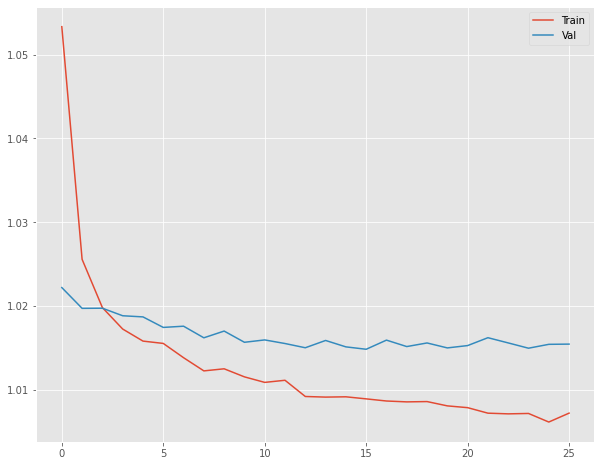

In [18]:
plt.plot(h.history['loss'], label='Train')
plt.plot(h.history['val_loss'], label='Val')
plt.legend();



In [21]:
def evaluate(model, X, y):
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)
    report = metrics.classification_report(y, preds)
    print(report)
    logloss = metrics.log_loss(y, probs)
    print('Log loss:', logloss)
    cm = metrics.confusion_matrix(y, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(target2int.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.show();

              precision    recall  f1-score   support

           0       0.49      0.44      0.46     19176
           1       0.33      0.00      0.00     15503
           2       0.49      0.82      0.62     25962

    accuracy                           0.49     60641
   macro avg       0.44      0.42      0.36     60641
weighted avg       0.45      0.49      0.41     60641

Log loss: 1.0148382273907284


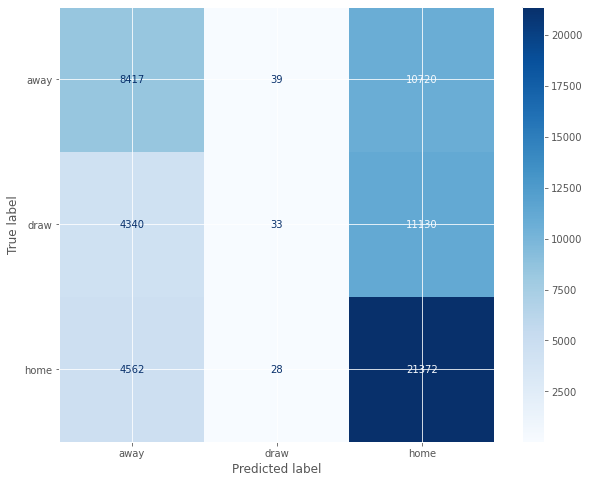

In [22]:
evaluate(model, X_val, y_val)

In [23]:
probs_test = model.predict(X_test)
probs_test

array([[0.2425128 , 0.31156278, 0.44592437],
       [0.32243747, 0.3083911 , 0.36917147],
       [0.34805965, 0.32008034, 0.33186   ],
       ...,
       [0.688486  , 0.1717179 , 0.13979617],
       [0.1656405 , 0.25695372, 0.57740575],
       [0.33545136, 0.28432772, 0.38022095]], dtype=float32)

In [24]:
df_sub = pd.DataFrame({
    'id': test['id'],
    'away': probs_test[:, 0],
    'draw': probs_test[:, 1],
    'home': probs_test[:, 2]
})
df_sub

,id,away,draw,home
0,17761448,0.242513,0.311563,0.445924
1,17695487,0.322437,0.308391,0.369171
2,17715496,0.348060,0.320080,0.331860
...,...,...,...,...
72708,18449018,0.688486,0.171718,0.139796
72709,17958831,0.165641,0.256954,0.577406
72710,18441629,0.335451,0.284328,0.380221


In [25]:
pd.concat([
    train['target_int'].value_counts(normalize=True).sort_index().rename('observed'),
    pd.Series(np.argmax(df_sub.iloc[:, 1:].values, axis=1), name='predicted').value_counts(normalize=True).sort_index()
], axis=1)

,observed,predicted
0,0.317057,0.305566
1,0.249252,0.001114
2,0.433691,0.693320


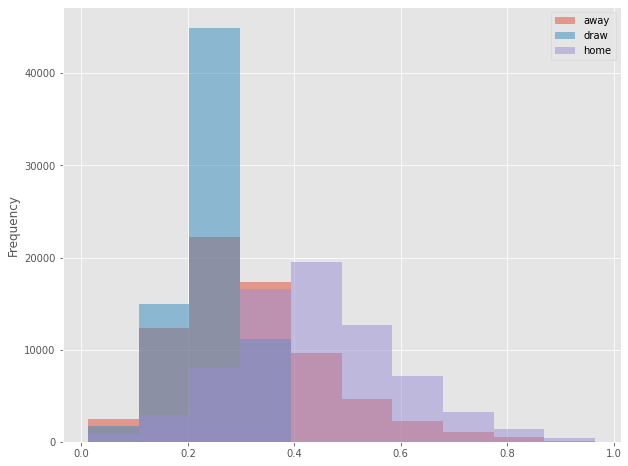

In [26]:
df_sub.iloc[:, 1:].plot.hist(alpha=0.5);

In [29]:
# submission expects this order: id, home, away, draw
df_sub[['id', 'home', 'away', 'draw']].to_csv('submission.csv', index=False)

In [33]:
k = pd.read_csv("submission.csv")
k.head()

,id,home,away,draw
0,17761448,0.445924,0.242513,0.311563
1,17695487,0.369171,0.322437,0.308391
2,17715496,0.331860,0.348060,0.320080
3,17715493,0.206129,0.534348,0.259523
4,17715492,0.481036,0.210721,0.308242


In [34]:
print("end")

end
